## A data analysis of ufo sightings. <br><br>This data was obtained from Kaggle (https://www.kaggle.com/code/hakeemtfrank/ufo-sightings-data-exploration/input) which was in turn obtained from NUFORC.

## Some questions to be asked:
-  Where do the most UFO sightings occur.
-  How do the number of sightings differ over the years.
-  Any trends in the distribution of UFO shapes over the years.
-  Any times of year, seasons especially rampant with aliens?
-  Do different shapes prefer certain areas. Say do 50% of spheres hang over Seattle?

In [1]:
# Import useful libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import datetime as dt

import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Read in the source data and display top 5 rows.
axdf=pd.read_csv('complete_v3.csv', on_bad_lines='skip',low_memory = False)
axdf.head(5)


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [2]:
df = axdf.sort_values('datetime')
df.tail()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
88674,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444
88675,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556
88677,9/9/2013 23:00,starr,sc,us,diamond,0,2 nights,On September ninth my wife and i noticed stran...,9/30/2013,34.3769444,-82.695833
88676,9/9/2013 23:00,edmond,ok,us,cigar,1020,17 minutes,2 witnesses 2 miles apart&#44 Red &amp; White...,9/30/2013,35.6527778,-97.477778
88678,9/9/2013 23:30,ft. lauderdale,fl,us,oval,0,still occuring,Hovering object lit with red and white lights&...,9/30/2013,26.1219444,-80.143611


## So lets have a look at what we have and try to clean up a little

In [3]:
axdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88679 entries, 0 to 88678
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              88679 non-null  object 
 1   city                  88679 non-null  object 
 2   state                 81270 non-null  object 
 3   country               76314 non-null  object 
 4   shape                 85757 non-null  object 
 5   duration (seconds)    88677 non-null  object 
 6   duration (hours/min)  85660 non-null  object 
 7   comments              88644 non-null  object 
 8   date posted           88679 non-null  object 
 9   latitude              88679 non-null  object 
 10  longitude             88679 non-null  float64
dtypes: float64(1), object(10)
memory usage: 7.4+ MB


In [4]:
axdf.shape

(88679, 11)

## I'm going to get rid of the duration columns because I will not be using that as a part of this analysis.

In [5]:
axdf.drop(columns=['duration (hours/min)', 'duration (seconds)'], inplace = True)

## Now lets check for duplicates and drop any.

In [6]:
duplicates = axdf.duplicated()
print(axdf[duplicates])

              datetime       city state country  shape            comments  \
69419   7/4/2013 22:00   shakopee    mn      us  light   Orange fast orbs.   
78211  8/30/2013 21:45  haymarket    va      us  light  2 bright lights...   

      date posted    latitude  longitude  
69419    7/5/2013  44.7980556 -93.526667  
78211    9/9/2013  38.8119444 -77.636667  


In [7]:
axdf.drop_duplicates(inplace = True)

## I should probably change the latitude and duration (seconds) columns to be numeric. I'll remove any (and there are) alpha characters first.

In [8]:
axdf['latitude'] = axdf['latitude'].str.replace("[a-zA-Z]",'', regex = True)
axdf['latitude'] = axdf['latitude'].astype(float)

## I want to remove leading and trailing spaces.

In [9]:
axdf['city'] = axdf['city'].str.strip()
axdf['country'] = axdf['country'].str.strip()
axdf['state'] = axdf['state'].str.strip()
axdf['shape'] = axdf['shape'].str.strip()

## Lets see some stats on the data.

In [10]:
axdf.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,88677.0,37.452935,11.572543,-82.862752,34.035000,39.233333,42.717778,72.7000
longitude,88677.0,-85.021824,41.422194,-176.658056,-112.073333,-87.650000,-77.770000,178.4419


## Lets see how many null and nan values we have

In [11]:
axdf.isnull().sum()

datetime           0
city               0
state           7409
country        12365
shape           2922
comments          35
date posted        0
latitude           0
longitude          0
dtype: int64

## And what percentage do they make up?

In [12]:
allnulls = axdf.isnull().sum()
pctOfNulls = (allnulls / len(axdf))*100
print(' Null Values (% of entries):')
print(round(pctOfNulls.sort_values(ascending=False),2))

 Null Values (% of entries):
country        13.94
state           8.36
shape           3.30
comments        0.04
datetime        0.00
city            0.00
date posted     0.00
latitude        0.00
longitude       0.00
dtype: float64


## Seems like a fair amount of absent countries that I will try to account for. I mean the observer had to be somewhere.

## To try and add missing countries I tried using the latitude and longitude I got from an online search for the U.S. but got a lot of Canadian locales popping up, and also it didn't include American territories outside of the U.S. so I will use a list of valid states and territories and create a new column based on the results. <br><br> First I'll make the state column upper case.

In [13]:
axdf['state'] = axdf['state'].str.upper()

## Create a holding column to store our country.

In [14]:
axdf['temp_country'] = ''

## I'm also going to try using geopandas to get the country from the latitude and longitude columns.

In [15]:
axdf['geopandas_country'] = ''

## Before I use geopandas I'm going to try and identify countries based on available data starting with the USA. <br>  Create our list of U.S. states including American territories. Then put 'US' in the temp_country column if the value in the state column is in this list.

In [16]:
statelist = ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
    "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
    "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
    "WV", "WY", "DC", "AS", "GU", "MP", "PR", "VI"]

In [17]:
axdf['temp_country'] = np.where((axdf['state'].isin(statelist)), 'United States of America', axdf['temp_country'])

In [18]:
axdf.head()

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
0,10/10/1949 20:30,san marcos,TX,us,cylinder,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,United States of America,
1,10/10/1949 21:00,lackland afb,TX,NaN,light,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,United States of America,
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,,
3,10/10/1956 21:00,edna,TX,us,circle,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,United States of America,
4,10/10/1960 20:00,kaneohe,HI,us,light,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,United States of America,


## I want to take a look at my own country, so lets take a peek at rows with co-ordinates that place the location in Great Britain. I know this does not reflect the United Kingdom as I have not included Northern Ireland, only because using the latitude and longitude would be tricky given the geography of the two.

## I will use the latitude and longitude to add GB to the temp_country column

In [19]:
for idx, lat, long in zip(axdf.index, axdf['latitude'], axdf['longitude']):
    if (lat >= 49 and lat <= 59) and (long >= -8 and long <= 2):
        axdf.at[idx, 'temp_country'] = 'GB'


In [20]:
axdf.head(5)

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
0,10/10/1949 20:30,san marcos,TX,us,cylinder,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,United States of America,
1,10/10/1949 21:00,lackland afb,TX,NaN,light,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,United States of America,
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,GB,
3,10/10/1956 21:00,edna,TX,us,circle,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,United States of America,
4,10/10/1960 20:00,kaneohe,HI,us,light,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,United States of America,


## I would now like to look for Canadian provinces in the state column using the same method as I used when looking for U,S, states and territories. <br>A few rows have 'ca' as country and the text '(canada)' in the city column but no state. I will update the new 'canada' column for these rows too.

In [21]:
canada_list = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT', 'PQ', 'SA', 'NF', 'YK']
axdf['temp_country'] = np.where((axdf['state'].isin(canada_list)), 'Canada', axdf['temp_country'])

In [22]:
axdf['temp_country'] = np.where((axdf['city'].str.contains("(canada)")) & (axdf['country'] == 'ca'), 'Canada', axdf['temp_country'])

In [23]:
axdf.loc[(axdf['country'] == 'ca')].head(5)

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
64,10/10/1994 23:00,toronto (greater toronto area) (canada),ON,ca,sphere,Large rusty sphere,7/3/2013,43.666667,-79.416667,Canada,
85,10/10/1998 22:30,st. john&#39s (canada),NF,ca,egg,Started off as 3 points of intense yellow ligh...,12/2/2000,47.550000,-52.666667,Canada,
104,10/10/2000 07:30,victoria (canada),BC,ca,cylinder,Smooth Shiny Cylinder,12/2/2000,46.216667,-63.483333,Canada,
113,10/10/2001 20:10,vancouver (canada),BC,ca,other,I observed an green object significantly above...,5/12/2011,49.250000,-123.133333,Canada,
123,10/10/2002 19:45,victoria (canada),BC,ca,unknown,bright white light with black outline around i...,10/15/2002,46.216667,-63.483333,Canada,


## Just to see, lets look how many different countries there are

In [24]:
for i in axdf['country'].unique():
    print(i)

us
nan
gb
ca
au
de


## So not counting the NaN rows that just leaves Germany and Australia in the country column. I'm sure other countries are visited by aliens too though. I will modify the temp_country column values to reflect Germany and Australia.

In [25]:
axdf['temp_country'] = np.where(axdf['country'] == 'au', 'Australia', axdf['temp_country'])
axdf['temp_country'] = np.where(axdf['country'] == 'de', 'Germany', axdf['temp_country'])

## As you can see below that still leaves a fair few rows with no identified country, so for the purpose of this exercise I will mark them as 'Unable To Verify'

In [26]:
print('Number of rows with missing country before analysis')
print(axdf.loc[axdf['country'].isnull()].shape[0])
print('Number of rows with unidentified countries afterwards')
print(axdf[axdf['temp_country'] == ''].shape[0])


Number of rows with missing country before analysis
12365
Number of rows with unidentified countries afterwards
4091


In [27]:
axdf['temp_country'] = np.where(axdf['temp_country'] == '', 'Unable To Verify', axdf['temp_country'])

## Now I'm going to try geopandas to check for countries

In [28]:

# Load country boundaries shapefile (or GeoJSON)
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Create GeoDataFrame using WGS 84 coordinate system (EPSG:4326)
gdf = gpd.GeoDataFrame(axdf, geometry=gpd.points_from_xy(axdf.longitude, axdf.latitude), crs="EPSG:4326")


In [29]:
# Use a spatial join to match each point with a geopandas country polygon
gdf = gpd.sjoin(gdf, world[['ADMIN', 'geometry']], how="left", predicate="within")
axdf['geopandas_country'] = gdf['ADMIN']

## And lets see what we got.

In [30]:
axdf['geopandas_country'].unique()

array(['United States of America', 'United Kingdom', nan, 'Canada',
       'New Zealand', 'Russia', 'Puerto Rico', 'Australia', 'Lithuania',
       'Norway', 'Iceland', 'Mexico', 'Austria', 'Japan', 'Vietnam',
       'Turkey', 'China', 'Peru', 'Greece', 'Iraq', 'Malaysia', 'Armenia',
       'France', 'Chile', 'Indonesia', 'India', 'Portugal', 'Hungary',
       'Germany', 'Sweden', 'Philippines', 'Venezuela', 'Pakistan',
       'Iran', 'Afghanistan', 'Morocco', 'Taiwan', 'Saudi Arabia',
       'eSwatini', 'Croatia', 'Colombia', 'Palestine', 'Romania', 'Egypt',
       'Brazil', 'Poland', 'Republic of Serbia', 'South Africa', 'Panama',
       'Belgium', 'South Korea', 'Honduras', 'Italy', 'Netherlands',
       'Ireland', 'Dominican Republic', 'Albania', 'North Macedonia',
       'Finland', 'Argentina', 'Northern Cyprus', 'Namibia', 'Bangladesh',
       'Jamaica', 'Syria', 'United Arab Emirates', 'Thailand', 'Spain',
       'Sri Lanka', 'Greenland', 'Kuwait', 'Ukraine', 'Bulgaria',
       

## replace GB with United Kingdom

In [31]:
axdf["temp_country"] = np.where(axdf["temp_country"] == "GB", 'United Kingdom', axdf["temp_country"])

## Just to see. I want to find any rows with countries I have identified that geopandas hasn't.

In [32]:
axdf.loc[(~(axdf['temp_country']== 'Unable To Verify') & (axdf['geopandas_country'].isnull()))].head(10)

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
19,10/10/1974 17:00,willow beach,AZ,NaN,light,The object was a brillant white light standing...,2/18/2001,0.000000,0.000000,United States of America,NaN
42,10/10/1987 20:00,manilla (rr#1) (canada),ON,NaN,disk,We could clearly see the craft and observed in...,8/5/2001,0.000000,0.000000,Canada,NaN
50,10/10/1990 20:00,pense (canada),SA,NaN,unknown,i saw something one rainy night&#44 and i&#39l...,10/12/2001,0.000000,0.000000,Canada,NaN
52,10/10/1991 22:00,frisco,NC,us,unknown,A friend and myself were standing on the shore...,1/28/1999,35.235000,-75.628889,United States of America,NaN
88,10/10/1999 03:00,st. agnes de dundee (canada),PQ,NaN,egg,early morning bright object egg shape fully co...,12/2/2000,0.000000,0.000000,Canada,NaN
103,10/10/2000 06:15,boynton beach,FL,us,other,Unusual light formation moving extremely fast ...,12/2/2000,26.525000,-80.066667,United States of America,NaN
110,10/10/2000 22:00,port orchard,WA,us,diamond,One night my window started to flash,5/12/2009,47.540556,-122.635000,United States of America,NaN
189,10/10/2007 20:24,west palm beach florida,FL,NaN,fireball,Burning ball across the sky over central/south...,11/28/2007,26.705621,-80.036430,United States of America,NaN
386,10/11/2004 22:30,eastsound,WA,us,sphere,like a bright star&#44 only spins slowly and ...,10/27/2004,48.696944,-122.904167,United States of America,NaN
387,10/11/2004 23:00,lake worth,FL,us,formation,Multiple formations viewed by three witnesses.,10/27/2004,26.615556,-80.057222,United States of America,NaN


## And any rows with countries I couldn't identify that geopandas has.

In [33]:
axdf.loc[((axdf['temp_country']== 'Unable To Verify') & ~(axdf['geopandas_country'].isnull()))].head(10)

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
36,10/10/1982 07:00,gisborne (new zealand),NaN,NaN,disk,gisborne nz 1982 wainui beach to sponge bay,1/11/2002,-38.662334,178.017649,Unable To Verify,New Zealand
58,10/10/1993 03:00,zlatoust (russia),NaN,NaN,sphere,I woke up at night and looked out the window n...,12/14/2004,55.183333,59.650000,Unable To Verify,Russia
69,10/10/1996 20:00,lake macquarie (nsw&#44 australia),NaN,NaN,light,RED LIGHT WITH OTHER RED FLASHING LIGHT&#44 ON...,5/24/1999,-33.093373,151.588982,Unable To Verify,Australia
147,10/10/2004 15:20,kedainiai (lithuania),NaN,NaN,oval,6 oval light objects very quickly rounded unde...,10/27/2004,55.288131,23.957728,Unable To Verify,Lithuania
199,10/10/2007 23:20,stord (norway),NaN,NaN,light,Thise could be an ETV case&#44 but it could al...,1/21/2008,59.900209,5.282347,Unable To Verify,Norway
321,10/11/1997 22:00,hafnarfjordur (iceland),NaN,NaN,sphere,playing with a jet,6/12/2008,64.066667,-21.950000,Unable To Verify,Iceland
380,10/11/2004 10:00,nuevo laredo (mexico),NaN,NaN,light,While I was driving I stopped at a traffic lig...,7/16/2006,27.477936,-99.549573,Unable To Verify,Mexico
421,10/11/2007 19:28,brassall (australia),NaN,NaN,unknown,Accidentally photographed very strange UFO,11/28/2007,-27.597553,152.745500,Unable To Verify,Australia
427,10/11/2008 00:00,klagenfurt (austria),NaN,NaN,chevron,It came from the direction of the city&#44 whe...,3/19/2009,46.627940,14.308990,Unable To Verify,Austria
432,10/11/2008 17:30,bellmere (australia),NaN,NaN,cylinder,Very large long white cylinder object travelin...,1/10/2009,-27.088079,152.928057,Unable To Verify,Australia


## And now rows that I either couldn't identify or geopandas could not but not both.

In [34]:
axdf.loc[(axdf['temp_country'] == 'Unable To Verify') ^ (axdf['geopandas_country'].isna())].head(10)

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
19,10/10/1974 17:00,willow beach,AZ,NaN,light,The object was a brillant white light standing...,2/18/2001,0.000000,0.000000,United States of America,NaN
36,10/10/1982 07:00,gisborne (new zealand),NaN,NaN,disk,gisborne nz 1982 wainui beach to sponge bay,1/11/2002,-38.662334,178.017649,Unable To Verify,New Zealand
42,10/10/1987 20:00,manilla (rr#1) (canada),ON,NaN,disk,We could clearly see the craft and observed in...,8/5/2001,0.000000,0.000000,Canada,NaN
50,10/10/1990 20:00,pense (canada),SA,NaN,unknown,i saw something one rainy night&#44 and i&#39l...,10/12/2001,0.000000,0.000000,Canada,NaN
52,10/10/1991 22:00,frisco,NC,us,unknown,A friend and myself were standing on the shore...,1/28/1999,35.235000,-75.628889,United States of America,NaN
58,10/10/1993 03:00,zlatoust (russia),NaN,NaN,sphere,I woke up at night and looked out the window n...,12/14/2004,55.183333,59.650000,Unable To Verify,Russia
69,10/10/1996 20:00,lake macquarie (nsw&#44 australia),NaN,NaN,light,RED LIGHT WITH OTHER RED FLASHING LIGHT&#44 ON...,5/24/1999,-33.093373,151.588982,Unable To Verify,Australia
88,10/10/1999 03:00,st. agnes de dundee (canada),PQ,NaN,egg,early morning bright object egg shape fully co...,12/2/2000,0.000000,0.000000,Canada,NaN
103,10/10/2000 06:15,boynton beach,FL,us,other,Unusual light formation moving extremely fast ...,12/2/2000,26.525000,-80.066667,United States of America,NaN
110,10/10/2000 22:00,port orchard,WA,us,diamond,One night my window started to flash,5/12/2009,47.540556,-122.635000,United States of America,NaN


## Update temp_country with geopandas_country if temp_country is 'Unable to verify' but there is a valid country in geopandas_country.

In [35]:
axdf['temp_country'] = np.where(
    (axdf['temp_country'] == 'Unable To Verify') & (axdf['geopandas_country'].notna()),
    axdf['geopandas_country'], axdf['temp_country'])

## Check on a sample of country counts

In [36]:
axdf['temp_country'].value_counts().head(25)

temp_country
United States of America    77361
Canada                       4011
United Kingdom               2622
Unable To Verify             1327
Australia                     685
India                         239
Mexico                        229
Germany                       152
Netherlands                   112
New Zealand                    96
Malaysia                       94
France                         81
Brazil                         77
South Africa                   71
Spain                          64
China                          54
Philippines                    44
Portugal                       44
Belgium                        43
Japan                          43
Iran                           39
Sweden                         38
Romania                        36
Norway                         35
Israel                         34
Name: count, dtype: int64

## Now lets look for rows still not identified with a country.

In [37]:
axdf.loc[axdf['temp_country']== 'Unable To Verify']

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
18,10/10/1973 23:00,bermuda nas,NaN,NaN,light,saw fast moving blip on the radar scope thin w...,1/11/2002,32.364167,-64.678611,Unable To Verify,NaN
76,10/10/1998 02:00,turin (italy),NaN,NaN,disk,We were doing a patrol during the night&#44me ...,1/19/2005,0.000000,0.000000,Unable To Verify,NaN
97,10/10/1999 22:00,dorset (uk/england),NaN,NaN,flash,Whilst out late night cycling (as i have done ...,2/14/2006,0.000000,0.000000,Unable To Verify,NaN
102,10/10/2000 03:45,carnival cruise ship (paradise) (caribbean),NaN,NaN,flash,Motionless eratic flashing light.,12/9/2000,0.000000,0.000000,Unable To Verify,NaN
126,10/10/2002 22:00,bahamas,NaN,NaN,egg,we are sitting outside and commenting on all t...,10/15/2002,25.034280,-77.396280,Unable To Verify,NaN
...,...,...,...,...,...,...,...,...,...,...,...
88358,9/8/2011 22:00,watertown,NaN,NaN,sphere,Orb changing colors and staying in sight while...,10/10/2011,0.000000,0.000000,Unable To Verify,NaN
88436,9/9/1981 20:00,moca (puerto rico),NaN,NaN,triangle,Huge triangle with three smaller saucers at th...,10/31/2008,0.000000,0.000000,Unable To Verify,NaN
88459,9/9/1999 23:00,cozumel (mexico) and ocho rios (jamaica) (betw...,NaN,NaN,triangle,My husband and I&#44 while traveling on our ho...,10/2/1999,20.422984,-86.922343,Unable To Verify,NaN
88484,9/9/2002 02:25,lisbon (portugal),NaN,NaN,chevron,chevron formed by dim white lights moving nort...,9/19/2002,0.000000,0.000000,Unable To Verify,NaN


## So I'm going to lose the rows whose country I could not identify

In [38]:
IndexLat = axdf[axdf['temp_country'] == 'Unable To Verify'].index
axdf.drop(IndexLat , inplace=True)

## So lets populate the country column values with the values found by the searches.

In [39]:
axdf['country'] = axdf['temp_country']

In [40]:
axdf.head()

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,temp_country,geopandas_country
0,10/10/1949 20:30,san marcos,TX,United States of America,cylinder,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,United States of America,United States of America
1,10/10/1949 21:00,lackland afb,TX,United States of America,light,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,United States of America,United States of America
2,10/10/1955 17:00,chester (uk/england),NaN,United Kingdom,circle,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,United Kingdom,United Kingdom
3,10/10/1956 21:00,edna,TX,United States of America,circle,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,United States of America,United States of America
4,10/10/1960 20:00,kaneohe,HI,United States of America,light,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,United States of America,United States of America


## Lets check our null values again.

In [41]:
axdf.isnull().sum()

datetime                0
city                    0
state                6082
country                 0
shape                2866
comments               34
date posted             0
latitude                0
longitude               0
temp_country            0
geopandas_country    2665
dtype: int64

## So lets fill in null values with either a blank or, in the case of shape of UFO, lets leave it as 'Unknow'. I'm sure the shock was just too much for anyone to pay that much attention.

In [42]:
axdf['comments'] = axdf['comments'].fillna('')
axdf['state'] = axdf['state'].fillna('')
axdf['shape'] = axdf['shape'].fillna('Unknown')


## So lets have a look to see how many null values we now have.

In [43]:
axdf.isnull().sum()

datetime                0
city                    0
state                   0
country                 0
shape                   0
comments                0
date posted             0
latitude                0
longitude               0
temp_country            0
geopandas_country    2665
dtype: int64

In [44]:
axdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87350 entries, 0 to 88678
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           87350 non-null  object 
 1   city               87350 non-null  object 
 2   state              87350 non-null  object 
 3   country            87350 non-null  object 
 4   shape              87350 non-null  object 
 5   comments           87350 non-null  object 
 6   date posted        87350 non-null  object 
 7   latitude           87350 non-null  float64
 8   longitude          87350 non-null  float64
 9   temp_country       87350 non-null  object 
 10  geopandas_country  84685 non-null  object 
dtypes: float64(2), object(9)
memory usage: 8.0+ MB


## So now that the data is cleaned up somewhat I'm going get more functional with it. <br> First I'll break the datetime column up into its various pieces. <br><br>I want to convert the datetime cells into actual datetime format so that if any have a time of 24:00 I will replace the time with 00:00 and add a day. I'm assuming here that the day ends at 24:00 and begins at 00:00.

In [45]:
axdf.loc[166]

datetime                                              10/10/2005 24:00
city                                                          franklin
state                                                               IN
country                                       United States of America
shape                                                             disk
comments             two yellow objects sitting over the corn field...
date posted                                                 10/20/2005
latitude                                                     39.480556
longitude                                                      -86.055
temp_country                                  United States of America
geopandas_country                             United States of America
Name: 166, dtype: object

In [46]:
axdf['date_observed'] = pd.to_datetime(
    axdf['datetime'].str.replace(' 24:00', ' 00:00', regex=False), errors='coerce'
)


axdf['date_observed'] += np.where(
    axdf['date_observed'].dt.hour == 0, pd.Timedelta(days=1), pd.Timedelta(0)
)


In [47]:
axdf.loc[166]

datetime                                              10/10/2005 24:00
city                                                          franklin
state                                                               IN
country                                       United States of America
shape                                                             disk
comments             two yellow objects sitting over the corn field...
date posted                                                 10/20/2005
latitude                                                     39.480556
longitude                                                      -86.055
temp_country                                  United States of America
geopandas_country                             United States of America
date_observed                                      2005-10-11 00:00:00
Name: 166, dtype: object

## remove unneccessary columns

In [48]:
axdf.drop(['temp_country', 'geopandas_country', 'datetime', 'date posted', 'comments'], axis=1, inplace=True)

In [49]:
axdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87350 entries, 0 to 88678
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city           87350 non-null  object 
 1   state          87350 non-null  object 
 2   country        87350 non-null  object 
 3   shape          87350 non-null  object 
 4   latitude       87350 non-null  float64
 5   longitude      87350 non-null  float64
 6   date_observed  87350 non-null  object 
dtypes: float64(2), object(5)
memory usage: 7.3+ MB


## Convert date observed to datetime and break into individual componenets.

In [50]:
axdf['date_observed'] = pd.to_datetime(axdf['date_observed'])

In [51]:
axdf['year_seen'] = axdf['date_observed'].dt.year
axdf['month_seen'] = axdf['date_observed'].dt.month
axdf['day_seen'] = axdf['date_observed'].dt.day
axdf['hour_seen'] = axdf['date_observed'].dt.hour

In [52]:
axdf.tail(4)

,city,state,country,shape,latitude,longitude,date_observed,year_seen,month_seen,day_seen,hour_seen
88675,vienna,VA,United States of America,circle,38.901111,-77.265556,2013-09-09 22:20:00,2013,9,9,22
88676,edmond,OK,United States of America,cigar,35.652778,-97.477778,2013-09-09 23:00:00,2013,9,9,23
88677,starr,SC,United States of America,diamond,34.376944,-82.695833,2013-09-09 23:00:00,2013,9,9,23
88678,ft. lauderdale,FL,United States of America,oval,26.121944,-80.143611,2013-09-09 23:30:00,2013,9,9,23


In [53]:
axdf['shape'].unique()

array(['cylinder', 'light', 'circle', 'sphere', 'disk', 'fireball',
       'unknown', 'oval', 'other', 'cigar', 'rectangle', 'chevron',
       'triangle', 'formation', 'Unknown', 'delta', 'changing', 'egg',
       'diamond', 'flash', 'cross', 'teardrop', 'cone', 'pyramid',
       'round', 'crescent', 'flare', 'hexagon', 'dome', 'changed'],
      dtype=object)

## There's a few reported shapes that are similar so I want to group some together.

In [54]:
mapped_shapes = {"circle": "round",
                 "sphere": "round",
                 "disk": "round",
                 "round": "round",
                 "cylinder": "cylinder",
                 "cigar": "cylinder",
                 "oval": "cylinder",
                 "triangle": "triangle",
                 "delta": "triangle",
                 "cone": "triangle",
                 "pyramid": "triangle",
                 "light": "light",
                 "fireball": "light",
                 "flash": "light",
                 "flare": "light",
                 "square": "angular",
                 "hexagon": "angular",
                 "rectangle": "angular",
                 "egg": "egg",
                 "teardrop": "egg",
                 "unknown": "unknown",
                 "Unknown": "unknown",
                 "changed": "changing",
                 "changing": "changing"
                 }

axdf['new_shape'] = axdf['shape'].map(mapped_shapes)
          

In [55]:
axdf.head()

,city,state,country,shape,latitude,longitude,date_observed,year_seen,month_seen,day_seen,hour_seen,new_shape
0,san marcos,TX,United States of America,cylinder,29.883056,-97.941111,1949-10-10 20:30:00,1949,10,10,20,cylinder
1,lackland afb,TX,United States of America,light,29.384210,-98.581082,1949-10-10 21:00:00,1949,10,10,21,light
2,chester (uk/england),,United Kingdom,circle,53.200000,-2.916667,1955-10-10 17:00:00,1955,10,10,17,round
3,edna,TX,United States of America,circle,28.978333,-96.645833,1956-10-10 21:00:00,1956,10,10,21,round
4,kaneohe,HI,United States of America,light,21.418056,-157.803611,1960-10-10 20:00:00,1960,10,10,20,light


In [56]:
axdf['shape'].unique()

array(['cylinder', 'light', 'circle', 'sphere', 'disk', 'fireball',
       'unknown', 'oval', 'other', 'cigar', 'rectangle', 'chevron',
       'triangle', 'formation', 'Unknown', 'delta', 'changing', 'egg',
       'diamond', 'flash', 'cross', 'teardrop', 'cone', 'pyramid',
       'round', 'crescent', 'flare', 'hexagon', 'dome', 'changed'],
      dtype=object)

In [57]:
axdf['new_shape'].unique()

array(['cylinder', 'light', 'round', 'unknown', nan, 'angular',
       'triangle', 'changing', 'egg'], dtype=object)

### So lets update the 'shape' column.

In [58]:
axdf['shape'] = np.where(axdf['new_shape'].notna(), axdf['new_shape'], axdf['shape'])

In [59]:
axdf.drop(['new_shape'], axis=1, inplace=True)

## Now lets try to get the hemisphere these sightings occured in. <br> First I want to see what countries represent a row with no latitude value.

In [60]:
No_latitude = axdf[(axdf['latitude'] ==0) & ~(axdf['country'] == 'Unable To Verify')]

No_latitude['country'].unique()

array(['United States of America', 'Canada'], dtype=object)

## So just the U.S.A. and Canada, which I can mark down as being in the Northern hemisphere. <br> I will remove the rows that do not have a latitude or a recognised country.

In [61]:
# Set mapping for countries with a latitude that can define which hemisphere it is in.
country_hemisphere = {
    'United States of America': 'North',
    'Canada': 'North'
}

# Function to determine hemisphere
def determine_hemisphere(row):
    if row['latitude'] > 0:
        return 'North'
    elif row['latitude'] < 0:
        return 'South'
    elif row['latitude'] == 0 and row['country'] in country_hemisphere:
        return country_hemisphere[row['country']]
    else:
        return 'Unknown'  # For any cases that don’t fit the criteria

# Apply the function to each row in the dataframe
axdf['hemisphere'] = axdf.apply(determine_hemisphere, axis=1)


In [62]:
axdf['hemisphere'].nunique()

2

### There are a few as you will see below that did have latitude but as they are in North American countries I suspect an incorrect value.

In [63]:
err = axdf[(axdf['country'].isin(['Canada', 'United States of America'])) & (axdf['hemisphere'] == 'South')]
#axdf.loc[(axdf['country'].isin(['Canada', 'United States of America'])) & (axdf['hemisphere'] == 'South')]
err.head()

,city,state,country,shape,latitude,longitude,date_observed,year_seen,month_seen,day_seen,hour_seen,hemisphere
4499,remote,WY,United States of America,light,-46.163992,169.875050,2008-10-23 04:45:00,2008,10,23,4,South
4714,na,OH,United States of America,cylinder,-21.846665,19.188005,2004-10-24 23:27:00,2004,10,24,23,South
5993,unknown,WA,United States of America,triangle,-26.316667,113.333333,1995-10-30 21:30:00,1995,10,30,21,South
10347,atlantic ocean,MA,United States of America,round,-14.599413,-28.673147,1992-11-15 23:00:00,1992,11,15,23,South
10411,southwest,AR,United States of America,triangle,-38.416097,-63.616672,2000-11-15 08:30:00,2000,11,15,8,South


In [64]:
axdf['hemisphere'] = np.where(axdf['country'].isin(['Canada', 'United States of America']), 'North', axdf['hemisphere'])

In [65]:
axdf.loc[axdf['country'].isin(['Canada', 'United States of America'])]
#& axdf['hemisphere'] == 'South'

,city,state,country,shape,latitude,longitude,date_observed,year_seen,month_seen,day_seen,hour_seen,hemisphere
0,san marcos,TX,United States of America,cylinder,29.883056,-97.941111,1949-10-10 20:30:00,1949,10,10,20,North
1,lackland afb,TX,United States of America,light,29.384210,-98.581082,1949-10-10 21:00:00,1949,10,10,21,North
3,edna,TX,United States of America,round,28.978333,-96.645833,1956-10-10 21:00:00,1956,10,10,21,North
4,kaneohe,HI,United States of America,light,21.418056,-157.803611,1960-10-10 20:00:00,1960,10,10,20,North
5,bristol,TN,United States of America,round,36.595000,-82.188889,1961-10-10 19:00:00,1961,10,10,19,North
...,...,...,...,...,...,...,...,...,...,...,...,...
88674,napa,CA,United States of America,other,38.297222,-122.284444,2013-09-09 22:00:00,2013,9,9,22,North
88675,vienna,VA,United States of America,round,38.901111,-77.265556,2013-09-09 22:20:00,2013,9,9,22,North
88676,edmond,OK,United States of America,cylinder,35.652778,-97.477778,2013-09-09 23:00:00,2013,9,9,23,North
88677,starr,SC,United States of America,diamond,34.376944,-82.695833,2013-09-09 23:00:00,2013,9,9,23,North


In [66]:
axdf[axdf['hemisphere'] == 'South']['country'].unique()

array(['New Zealand', 'Australia', 'Peru', 'Chile', 'Indonesia',
       'eSwatini', 'Brazil', 'South Africa', 'Argentina', 'Bolivia',
       'Fiji', 'Zimbabwe', 'Kenya', 'Solomon Islands', 'Papua New Guinea',
       'Paraguay', 'Lesotho', 'Ecuador', 'United Republic of Tanzania',
       'Namibia', 'Zambia', 'East Timor', 'Botswana', 'Uruguay',
       'Antarctica', 'Uganda', 'Democratic Republic of the Congo'],
      dtype=object)

In [67]:
axdf.loc[(axdf['latitude'] == 0) & ~(axdf['country'].isin(['United States of America', 'Canada']))]


,city,state,country,shape,latitude,longitude,date_observed,year_seen,month_seen,day_seen,hour_seen,hemisphere


## Try to get the season from the day and month, taking hemisphere into account.

In [68]:
def get_season(row):
    month = row['month_seen']
    day = row['day_seen']
    hemisphere = row['hemisphere']

        
    #hemi = np.where(row['country'] in (countries_in_north), 'North', 'South')    #if row['latitude'] > 0 or (row['latitude'] == 0 and row['country'].isin(countries_in_north)):
    if hemisphere == 'North':        #Northern hemisphere
        if (month == 12 and day >= 21) or (month <= 3 and day <=21):
            return 'Winter'
        elif (month == 3 and day > 21) or (month <= 6 and day <=21):
            return 'Spring'
        elif (month == 6 and day > 21) or (month <= 9 and day <=21):
            return 'Summer'
        return 'Autumn'

    
    else:
        if (month == 12 and day >= 21) or (month <= 3 and day <=21):
            return 'Summer'
        elif (month == 3 and day > 21) or (month <= 6 and day <=21):
            return 'Autumn'
        elif (month == 6 and day > 21) or (month <= 9 and day <=21):
            return 'Winter'
        return 'Spring'
        
    
#axdf['temp_country'] = np.where((axdf['state'].isin(statelist)), 'USA', axdf['temp_country'])

axdf['season'] = axdf.apply(get_season, axis=1)


In [69]:
axdf['season'].value_counts()

season
Autumn    32450
Summer    23299
Spring    16544
Winter    15057
Name: count, dtype: int64

In [70]:
axdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87350 entries, 0 to 88678
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   city           87350 non-null  object        
 1   state          87350 non-null  object        
 2   country        87350 non-null  object        
 3   shape          87350 non-null  object        
 4   latitude       87350 non-null  float64       
 5   longitude      87350 non-null  float64       
 6   date_observed  87350 non-null  datetime64[ns]
 7   year_seen      87350 non-null  int32         
 8   month_seen     87350 non-null  int32         
 9   day_seen       87350 non-null  int32         
 10  hour_seen      87350 non-null  int32         
 11  hemisphere     87350 non-null  object        
 12  season         87350 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(4), object(6)
memory usage: 10.0+ MB


In [71]:
axdf.shape

(87350, 13)

## I want to see if there are any significant over or under representations of particular shape sightings in any county. That is compare the percentage of a specific shape in a country compared to the total sightings of that shape worldwide.

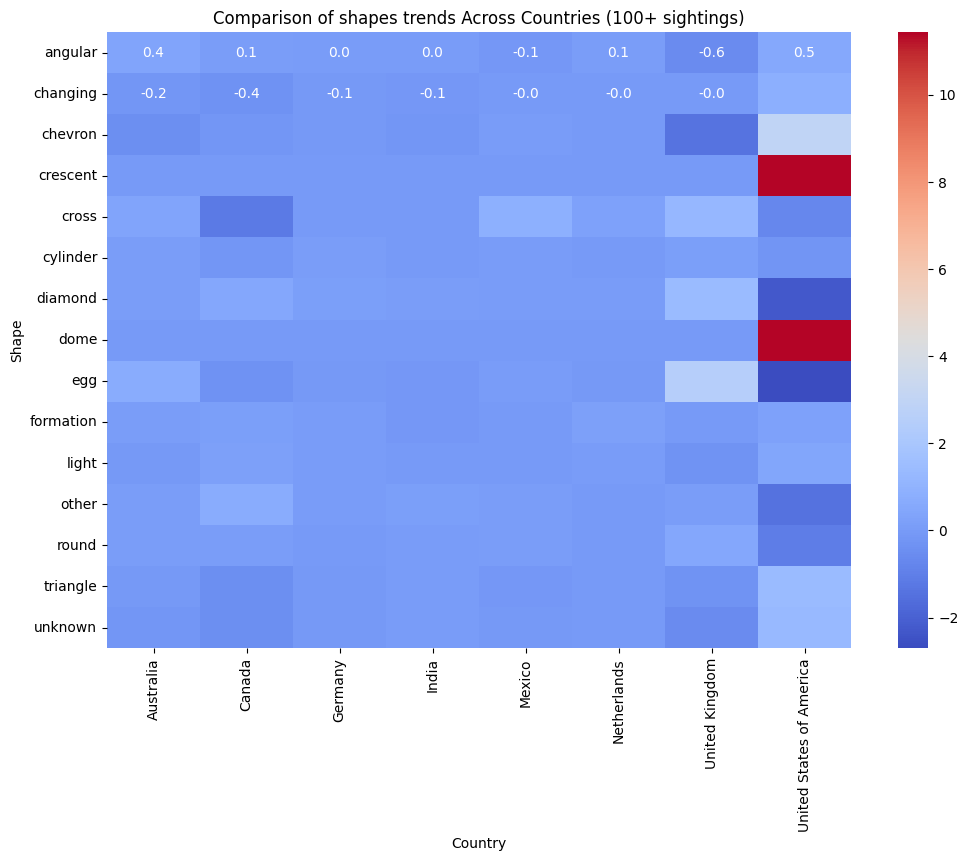

In [72]:
# Count the number of sightings for each combination of shape and country
shape_by_country_counts = axdf.groupby(['shape', 'country']).size().reset_index(name='combo_count')

# Calculate the total global number of sightings for each shape and merge into shape_by_country_counts
shape_counts = axdf['shape'].value_counts()
shape_by_country_counts = shape_by_country_counts.merge(
    shape_counts.rename('total_shape_count'),
    left_on='shape',
    right_index=True
)

# Get the percentage of sightings for each shape in a specific country relative to the total sightings of that shape.
shape_by_country_counts['shape_pct'] = (
    shape_by_country_counts['combo_count'] / shape_by_country_counts['total_shape_count']
) * 100

# Now I want to compare the ratio of sightings of a specific shape in a country against the countries total representation
# To start I will get the total sightings for each country and merge with shape_by_country_counts
country_counts = axdf['country'].value_counts()

shape_by_country_counts = shape_by_country_counts.merge(
    country_counts.rename('total_country_count'),
    left_on='country',
    right_index=True
)

# Get the percentage of total sightings for each country compared to total sightings
shape_by_country_counts['Country_Pct_of_Total'] = (
    shape_by_country_counts['total_country_count'] / axdf.shape[0]
) * 100

# Compare the percentages (shape-specific against overall country percentage). Essentially subtract one from the other. In an ideal 
# world the ratio between shape sightings and overall sightings would be 0 but......
# A positive value indicate this shape is overrepresented in the country compared to the country's share of all sightings.
# A negative value indicate this shape is underrepresented in the country compared to the country's share of all sightings.
shape_by_country_counts['Shape_vs_Country_Trend'] = (
    shape_by_country_counts['shape_pct'] - shape_by_country_counts['Country_Pct_of_Total']
)

# Filter to use countries with 100 or more sightings to get greater overall picture.
valid_countries = country_counts[country_counts >= 100].index
filtered_shape_country_counts = shape_by_country_counts[
    shape_by_country_counts['country'].isin(valid_countries)
]

# Create a pivot table with filtered data
filtered_pivot_table = filtered_shape_country_counts.pivot(
    index='shape', 
    columns='country', 
    values='Shape_vs_Country_Trend'
).fillna(0)


plt.figure(figsize=(12, 8))
sns.heatmap(filtered_pivot_table, annot=True, cmap="coolwarm", fmt=".1f", cbar=True)
plt.title('Comparison of shapes trends Across Countries (100+ sightings)')
plt.xlabel('Country')
plt.ylabel('Shape')
plt.show()


## So no major discrepancies.
## The huge positive trend in the USA with changed, crescent and dome shapes appear to be because it is the only country to have reported these particular occurences.
## egg shapes appear more prevalent in the UK than they do the USA, but other than that it appears our alien friends are not that picky about vehicular selection based on the geograpy.

## I want to get the part of the day of the sighting. Morning, Afternoon, Night etc.

In [73]:
# Define conditions for each time of day
hour = [
    (axdf['hour_seen'] >= 22) | (axdf['hour_seen'] < 5),  # Night: 22–23 and 0–4
    (axdf['hour_seen'] >= 5) & (axdf['hour_seen'] < 8),  # Dawn: 5–7
    (axdf['hour_seen'] >= 8) & (axdf['hour_seen'] < 12),  # Morning: 8–11
    (axdf['hour_seen'] >= 12) & (axdf['hour_seen'] < 17), # Afternoon: 12–16
    (axdf['hour_seen'] >= 17) & (axdf['hour_seen'] < 22)  # Evening/Dusk: 17–21
]

# Define corresponding labels
labels = ['Night', 'Dawn', 'Morning', 'Afternoon', 'Evening']

# Use np.select to match and assign the labels based on the conditions
axdf['time_of_day'] = np.select(hour, labels, default='Unknown')


## Now get the proportion each part of the day accounts for all sightings in the most active countries.

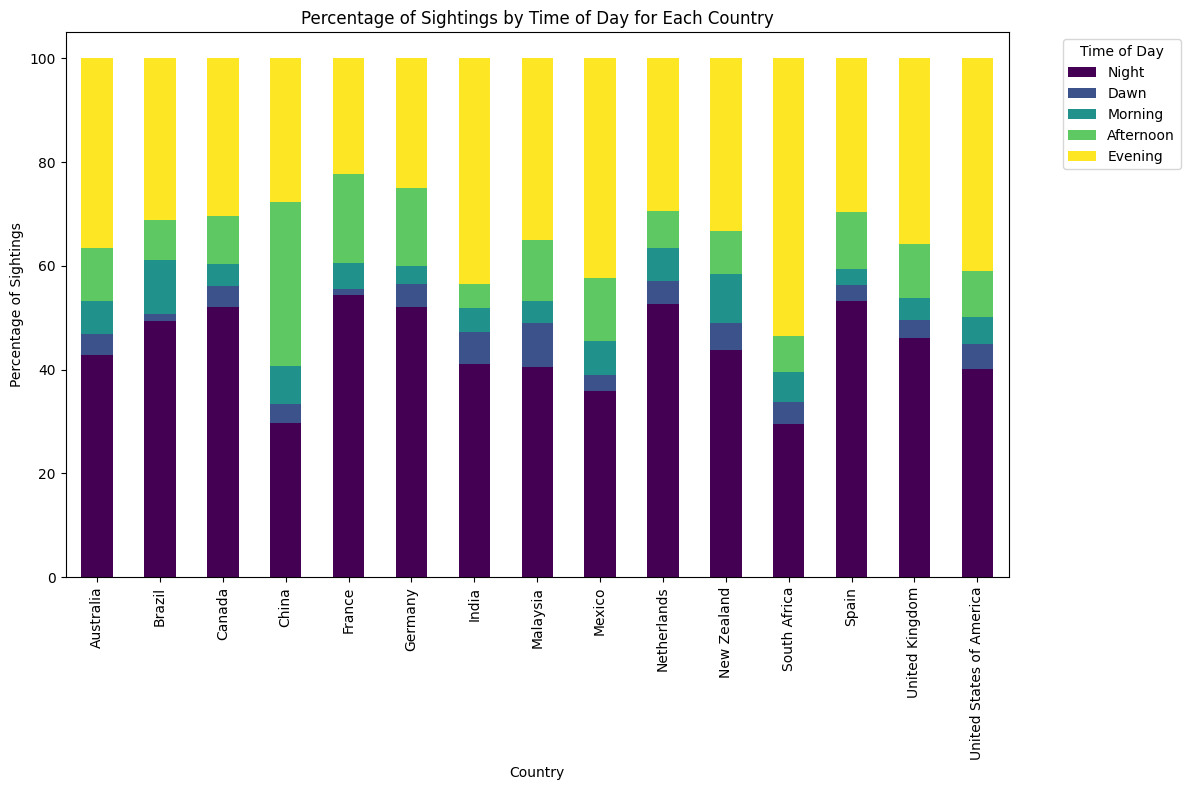

In [79]:
#select_country_df = axdf[axdf['country'].isin(['United States of America', 'United Kingdom', 'Canada', 'India', 'Brazil', 'Australia', 'Mexico', 'New Zealand', 'Netherlands'])]
# Select countries with the most sightings
filter_countries = axdf['country'].value_counts().reset_index(name='count').sort_values('count', ascending=False)[0:15]['country']

select_country_df = axdf[axdf['country'].isin(filter_countries)]   

# group by country and the time of day
day_part_counts = select_country_df.groupby(['country', 'time_of_day']).size().reset_index(name='count')

# Calculate total sightings for each country
country_totals = axdf['country'].value_counts()

# Merge totals back into the grouped DataFrame
day_part_counts = day_part_counts.merge(country_totals.rename('total'), left_on='country', right_index=True)

# Calculate percentage of the part of the day
day_part_counts['percentage'] = (day_part_counts['count'] / day_part_counts['total']) * 100

# Set order
time_order = ['Night', 'Dawn', 'Morning', 'Afternoon', 'Evening']

# Create a pivot table for counts of sightings by country and time of day
pivot_table = day_part_counts.pivot(index='country', columns='time_of_day', values='percentage').fillna(0)
pivot_table = pivot_table[time_order]


# Create stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.ylabel('Percentage of Sightings')
plt.xlabel('Country')
plt.title('Percentage of Sightings by Time of Day for Each Country')
plt.legend(title='Time of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## So the evening and night time the most prosperous. Perhaps unsurprising as bright objects in the sky would be more visible.

## Lets look at how the annual number of sightings changes over the years.

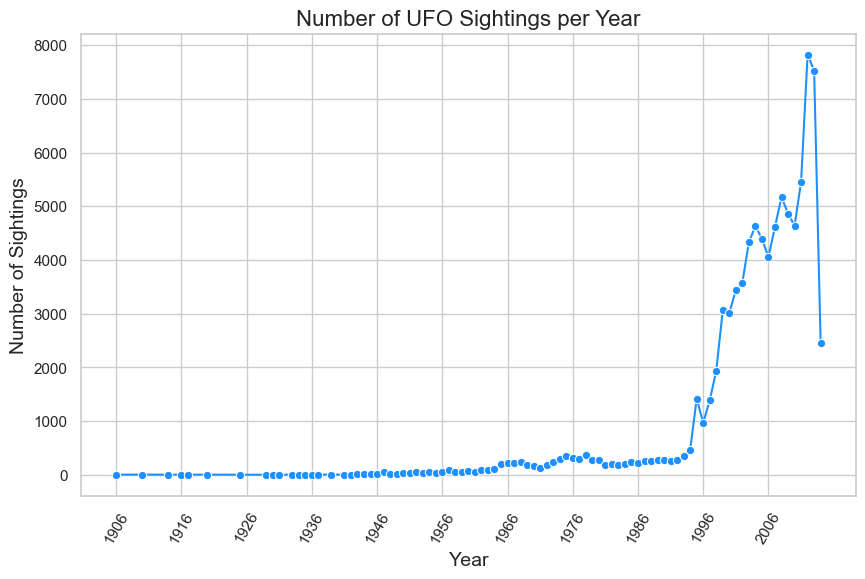

In [80]:

yearly_sightings = axdf['year_seen'].value_counts()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(yearly_sightings, marker='o', color='dodgerblue')

# Set x-axis to display every 10 years
plt.xticks(ticks=range(yearly_sightings.index.min(), yearly_sightings.index.max() + 1, 10))
plt.xticks(rotation = 60)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('Number of UFO Sightings per Year', fontsize=16)

plt.show()

## Things seem pretty stable, a slight increase over the years, up until the mid 90's where it really starts to heat up.  
### This may be because:  
  -  reporting sightings became easier with access to the Internet and portable technology
  -  people's perception especially with media coverage and just taking time to observe whats going on.
  - More secret or classified military exercises and overflights are occurring over populated areas
  - Just more aliens paying a visit.

## Because things seem like a slow steady rise for the most part I'm going to focus on sightings from the 90's onwards.

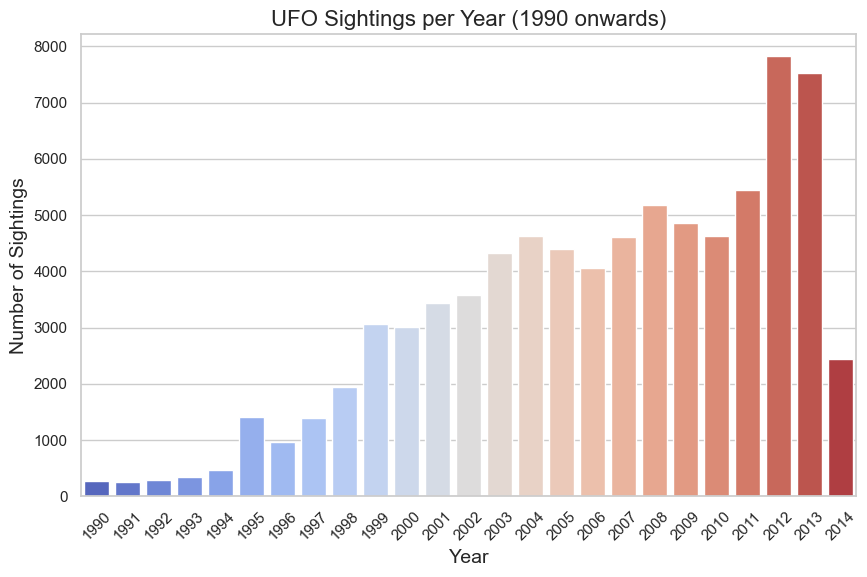

In [81]:
post90_df = axdf[axdf['year_seen'] >= 1990]

# Count sightings per year
sightings_per_year = post90_df['year_seen'].value_counts().reset_index()
sightings_per_year.columns = ['Year', 'Count']
sightings_per_year = sightings_per_year.sort_values('Year')

plt.figure(figsize=(10, 6))
sns.barplot(data=sightings_per_year, x='Year', y='Count', palette='coolwarm')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('UFO Sightings per Year (1990 onwards)', fontsize=16)
plt.xticks(rotation=45) 
plt.show()

## Something of a spike in 1995 (maybe something to do with a few alien based films coming out that year). Then steadily rising until a sharp spike in 2012 which was of course the end of the world, except it wasn't because the next year was also pretty high. Still a certain degree of paranoia may have set in.

## Let me focus briefly on the more prolific countries outside the U.S.

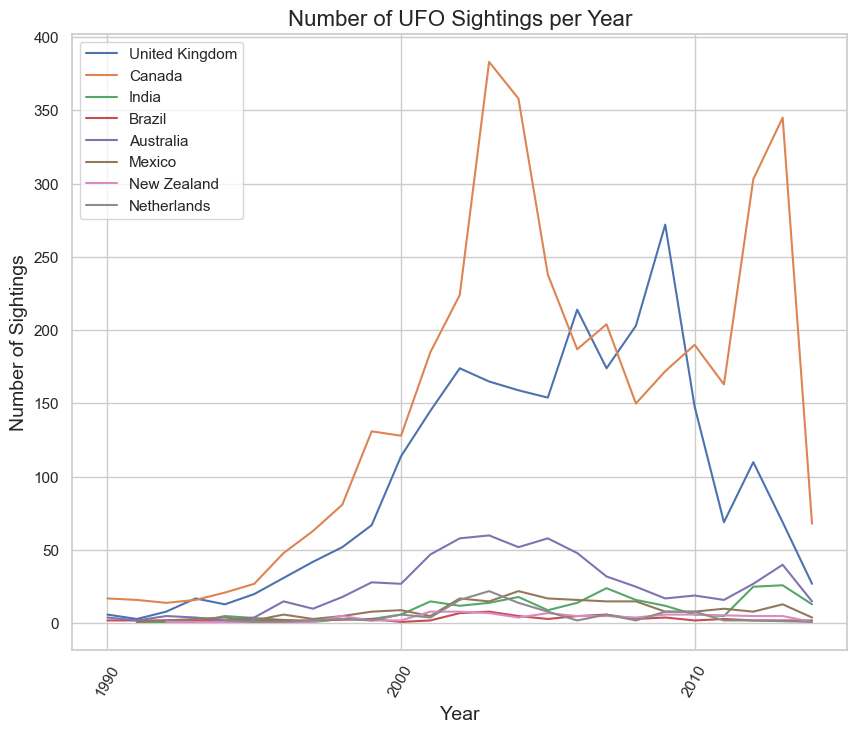

In [82]:
countries = ['United Kingdom', 'Canada', 'India', 'Brazil', 'Australia', 'Mexico', 'New Zealand', 'Netherlands']
post90_df = axdf[axdf['year_seen'] >= 1990]
yearly_sightings = post90_df['year_seen'].value_counts()
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))

for i in range(len(countries)):
    ufo_country = post90_df[post90_df['country'] == countries[i]]
    ufo_per_year_country = ufo_country['year_seen'].value_counts().sort_index()
    sns.lineplot(x = ufo_per_year_country.index, y = ufo_per_year_country.values, label = countries[i])

# Set x-axis to display every 10 years
plt.xticks(ticks=range(1990, yearly_sightings.index.max() + 1, 10))
plt.xticks(rotation = 60)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('Number of UFO Sightings per Year', fontsize=16)

plt.show()

## The trends are pretty much the same apart from Canada which had a  spike in 2002 and 2012. <br>  See https://ufobc.ca/Reports/banneryear.htm <br> and the U.K in 2008 <br> see https://www.upi.com/Top_News/2008/08/09/UFO-sightings-at-peak-in-Britain/21751218298699/.

## Lets take a look at the geographical distribution.

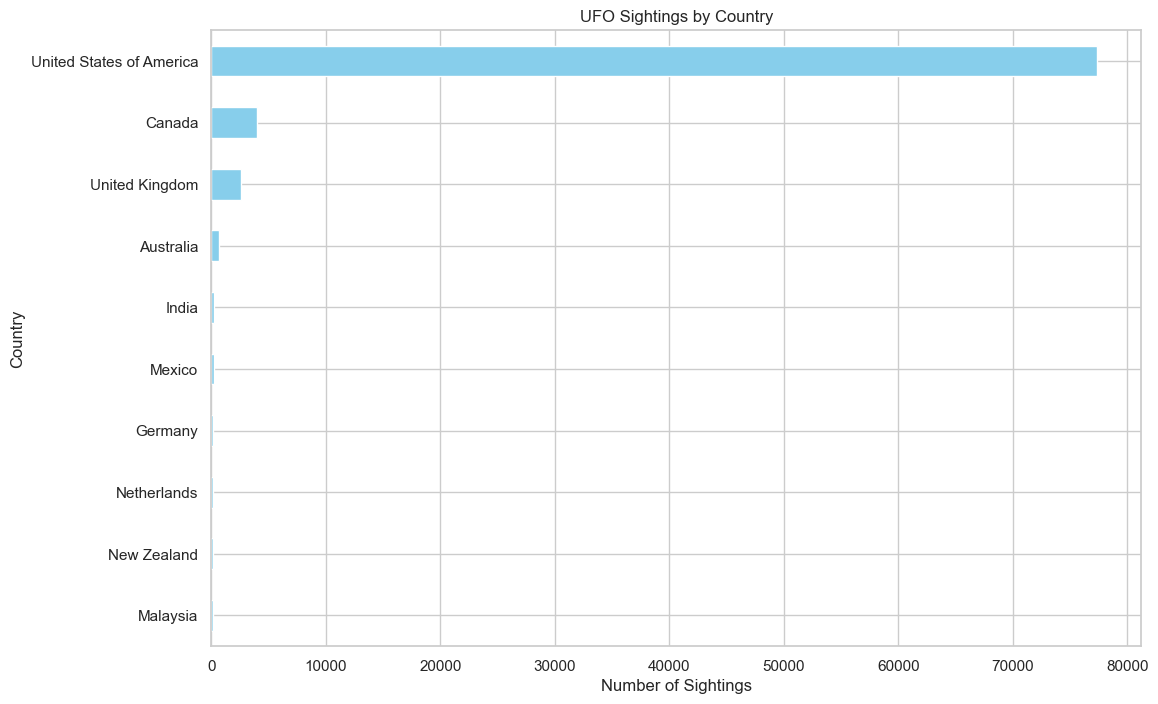

In [83]:
sightings_by_country = axdf['country'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sightings_by_country.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Sightings')
plt.ylabel('Country')
plt.title('UFO Sightings by Country')
plt.gca().invert_yaxis() 
plt.show()

## So no surprise the USA has by far and away the most sightings, bloody freaks, athough it may be that this data comes from NUFORC which is based in Washington state. So I'm going to take a look at countries outside the top 5 (U.S.A., Canada, U.K., Australia, India).

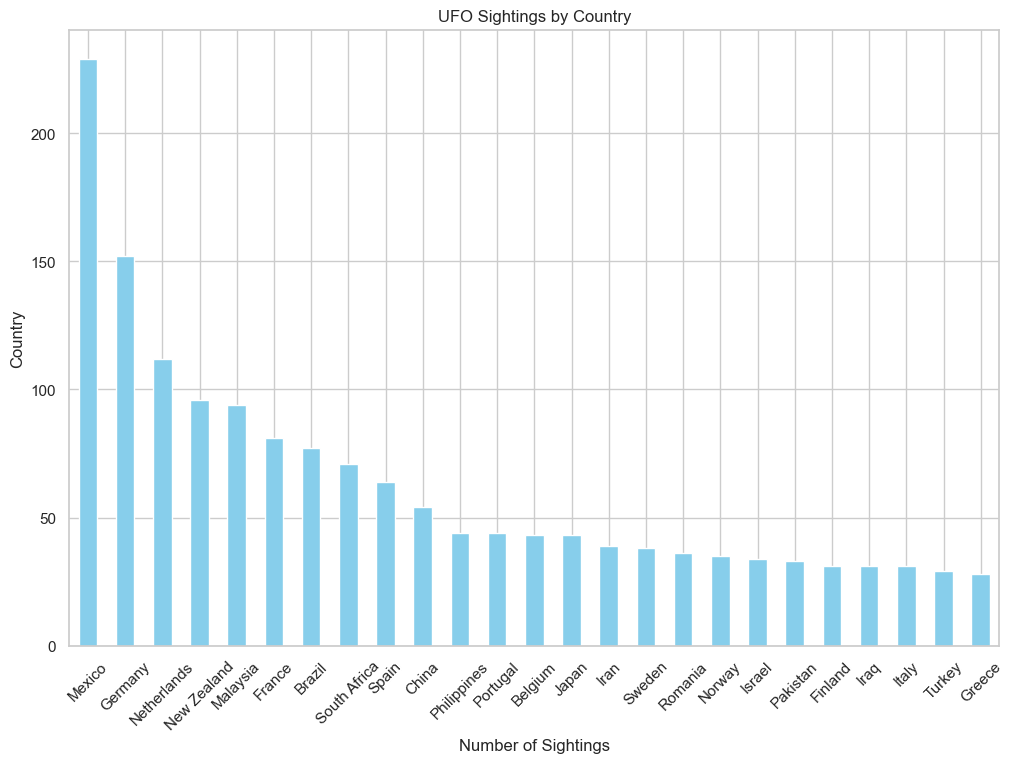

In [84]:
sightings_by_country = axdf['country'].value_counts()
sightings_slice = sightings_by_country.iloc[5:30]

plt.figure(figsize=(12, 8))
sightings_slice.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Sightings')
plt.ylabel('Country')
plt.title('UFO Sightings by Country')
plt.xticks(rotation=45) 

plt.show()

## So an eclectic mix of countries visitied by aliens.

## I want to see in any specific shapes had dominance at any particular time. This will show the ratio each shape had over the years. 0 means no presence and 1 means thats all there was.

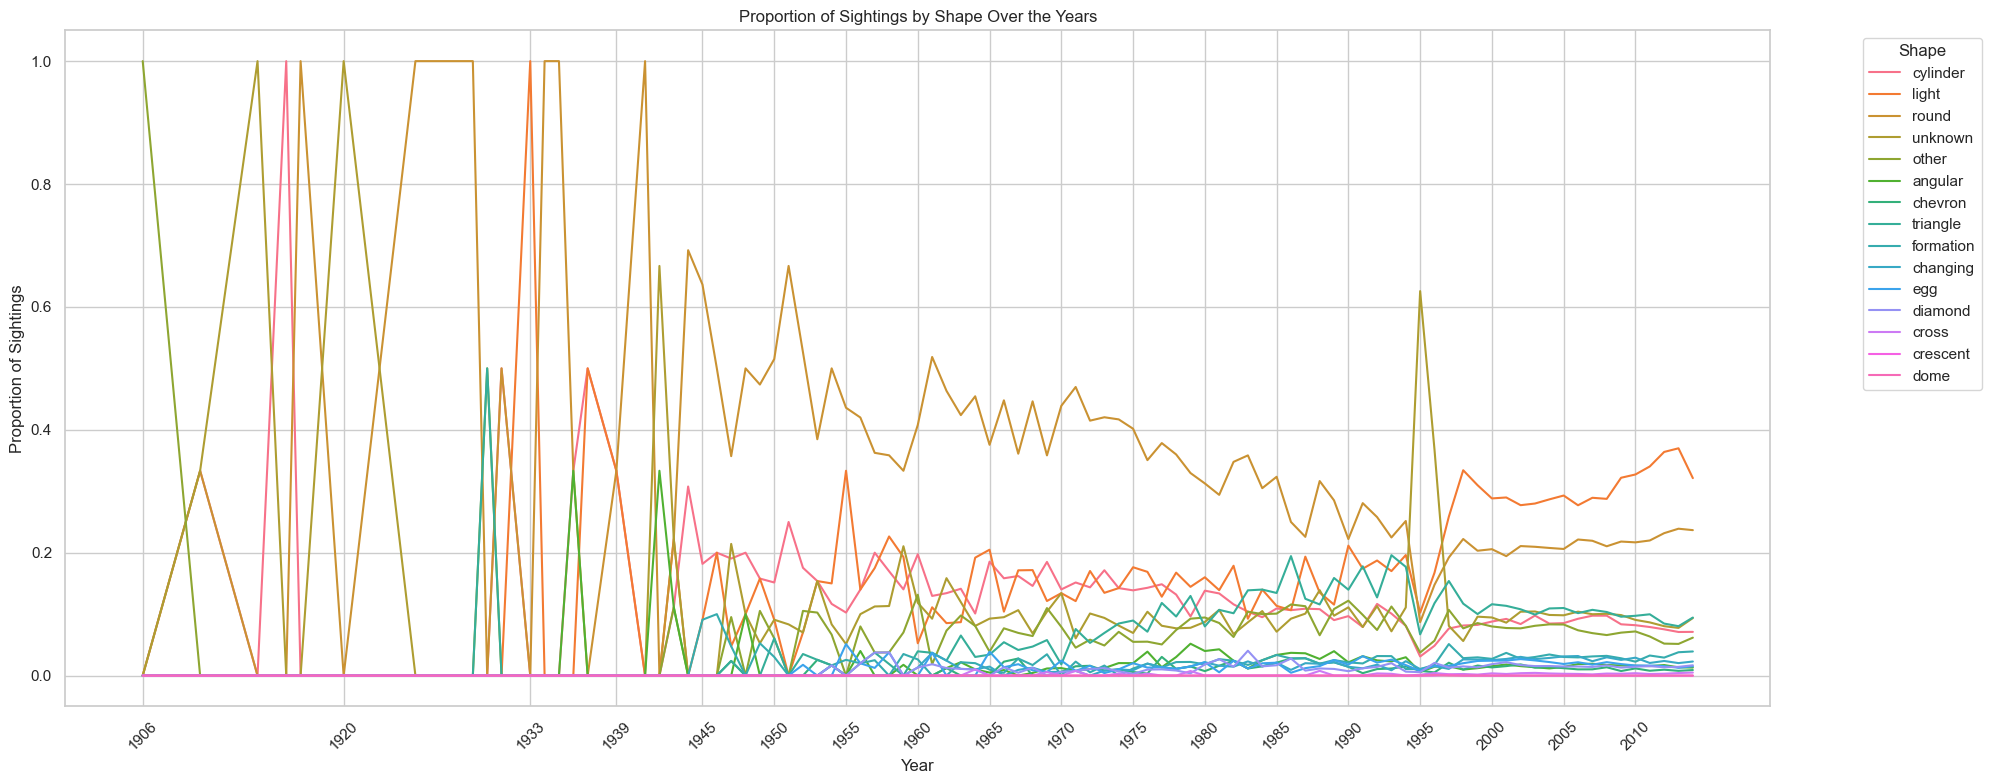

In [86]:
# Get all unique shapes and years
all_shapes = axdf['shape'].unique()
all_years = axdf['year_seen'].unique()

shape_year_counts = axdf.groupby(['shape', 'year_seen']).size().reset_index(name='shape_count')
yearly_counts = axdf.groupby('year_seen').size().reset_index(name='total_count')

shape_year_counts = shape_year_counts.merge(yearly_counts, on='year_seen')
shape_year_counts['proportion'] = shape_year_counts['shape_count'] / shape_year_counts['total_count']

# Create a cartesian join of shapes and years to get all possible combinations. This is so that I can correctly display missing values with 0.
complete_index = pd.MultiIndex.from_product([all_shapes, all_years], names=['shape', 'year_seen'])

# Going to reindex shape_year_counts to include all combinations, filling missing values with 0 and have index values as columns.
shape_year_counts = shape_year_counts.set_index(['shape', 'year_seen'])
shape_year_counts = shape_year_counts.reindex(complete_index, fill_value=0).reset_index()


# I had a problem with a duplicate 'total_count' column so I'm going to drop the 'total_count' column from shape_year_counts if it exists
if 'total_count' in shape_year_counts.columns:
    shape_year_counts = shape_year_counts.drop(columns=['total_count'])

# Merge shape_counts with yearly_counts
shape_year_counts = shape_year_counts.merge(yearly_counts, on='year_seen', how='left')

# Handle missing total_count values by filling with a zero.
shape_year_counts['total_count'].fillna(0, inplace=True)

# Recalculate proportions.
shape_year_counts['proportion'] = shape_year_counts['shape_count'] / shape_year_counts['total_count']
shape_year_counts['proportion'].fillna(0, inplace=True)

plt.figure(figsize=(20, 8))
sns.lineplot(data=shape_year_counts, x='year_seen', y='proportion', hue='shape')

years = sorted(shape_year_counts['year_seen'].unique())
plt.xticks(ticks=years[::5], rotation=45)

plt.xlabel('Year')
plt.ylabel('Proportion of Sightings')
plt.title('Proportion of Sightings by Shape Over the Years')
plt.legend(title='Shape', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## A little difficult to make out but in the early years, with fewer sightings, there were years when only one shape had been observed. Around the early 50's it seems to settle into a general mish-mash apart from an erratic 'round' shape and a huge spike for 'unknown' in 1997? A few shapes seem to be more popular than the others though.

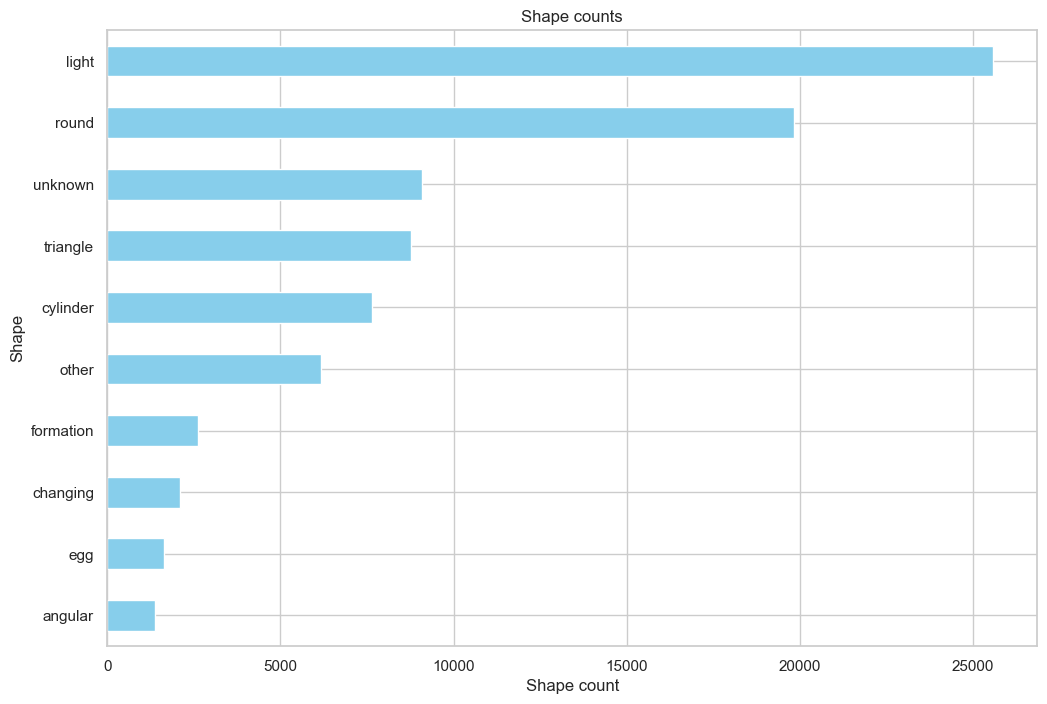

In [87]:
shapes = axdf['shape'].value_counts().head(10)

# Plot bar chart
plt.figure(figsize=(12, 8))
shapes.plot(kind='barh', color='skyblue')
plt.xlabel('Shape count')
plt.ylabel('Shape')
plt.title('Shape counts')
plt.gca().invert_yaxis() 
plt.show()

## Looks like 'light' and 'round' are the two most observed shapes. A 'light' shape could of course be any shape if it was at too great a distance to make out any detail. And 'round' is the conventional shape I suppose. If those cartoons are to be believed anyway.

## lets see when these shapes were first observed.

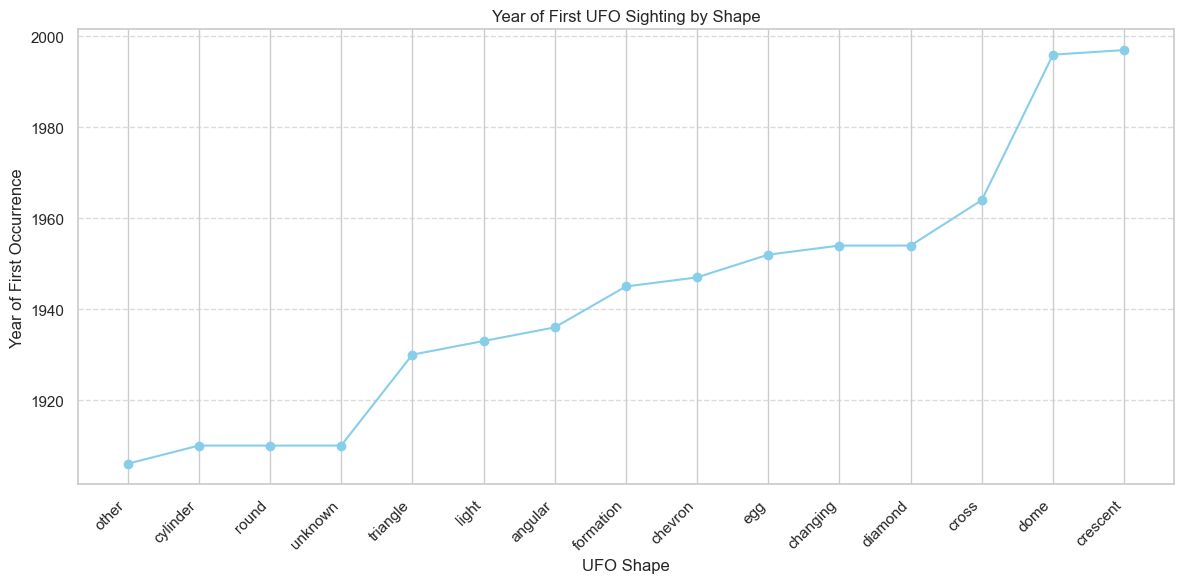

In [88]:

first_occurrence = axdf.groupby('shape')['year_seen'].min().reset_index()
first_occurrence.columns = ['shape', 'first_year']

# Sort by year
first_occurrence = first_occurrence.sort_values(by='first_year')

plt.figure(figsize=(12, 6))
plt.plot(first_occurrence['shape'], first_occurrence['first_year'], marker='o', linestyle='-', color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('UFO Shape')
plt.ylabel('Year of First Occurrence')
plt.title('Year of First UFO Sighting by Shape')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Looks like the 50's were a good time for first time space vehicle types. The most popular shapes 'light' and 'round' were first observed early on, although 'other' is the first observation. There are two new shapes in quick succession in the late 90's after a large gap.

## Lets see how the number of different shapes observed changed throughout the years.

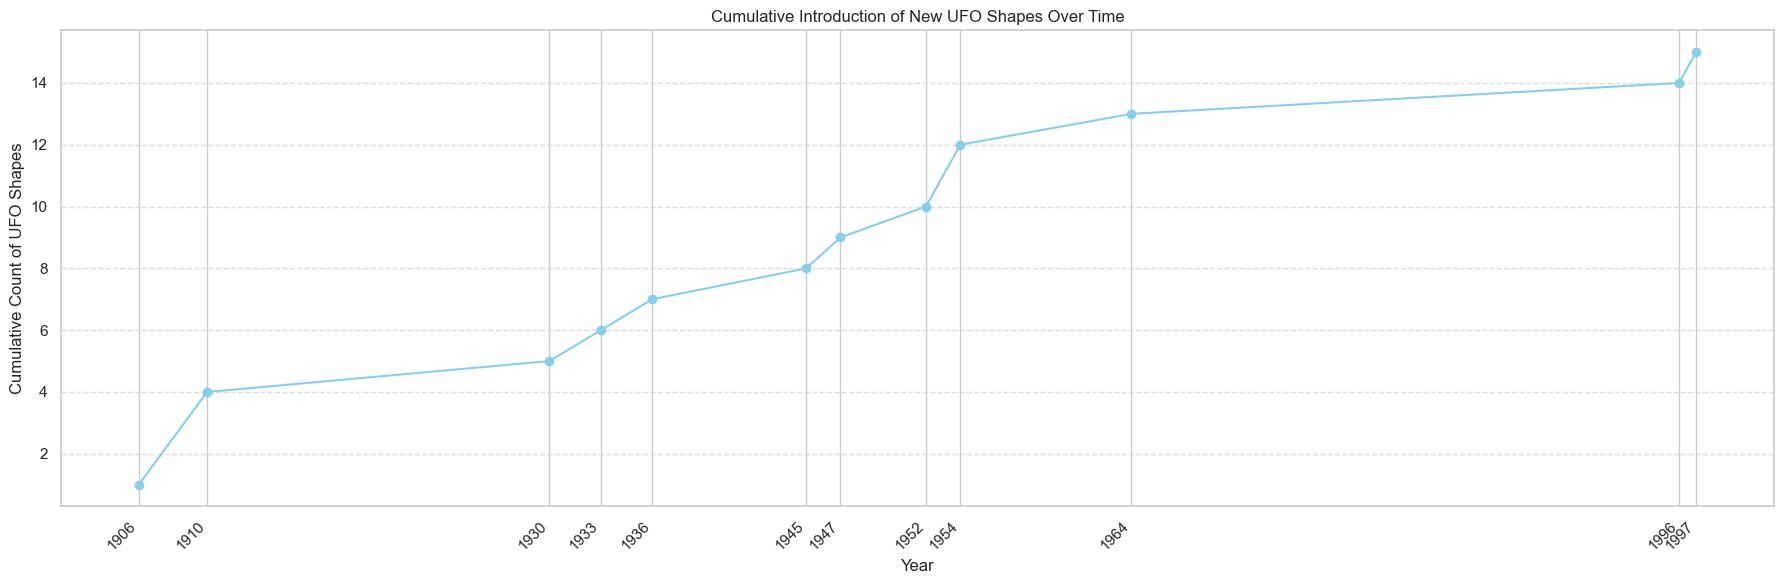

In [89]:
# Get a cumulative count of distinct shapes by year
cumulative_shapes = first_occurrence.groupby('first_year').size().cumsum().reset_index()
cumulative_shapes.columns = ['year', 'cumulative_count']

plt.figure(figsize=(18, 6), dpi=100)
plt.plot(cumulative_shapes['year'], cumulative_shapes['cumulative_count'], marker='o', linestyle='-', color='skyblue')
plt.xticks(cumulative_shapes['year'], rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Cumulative Count of UFO Shapes')
plt.title('Cumulative Introduction of New UFO Shapes Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Again it shows the 50's being a good time for first time viewing of a particular shape.

## I want to see if the time of day bears any correlation to the months.

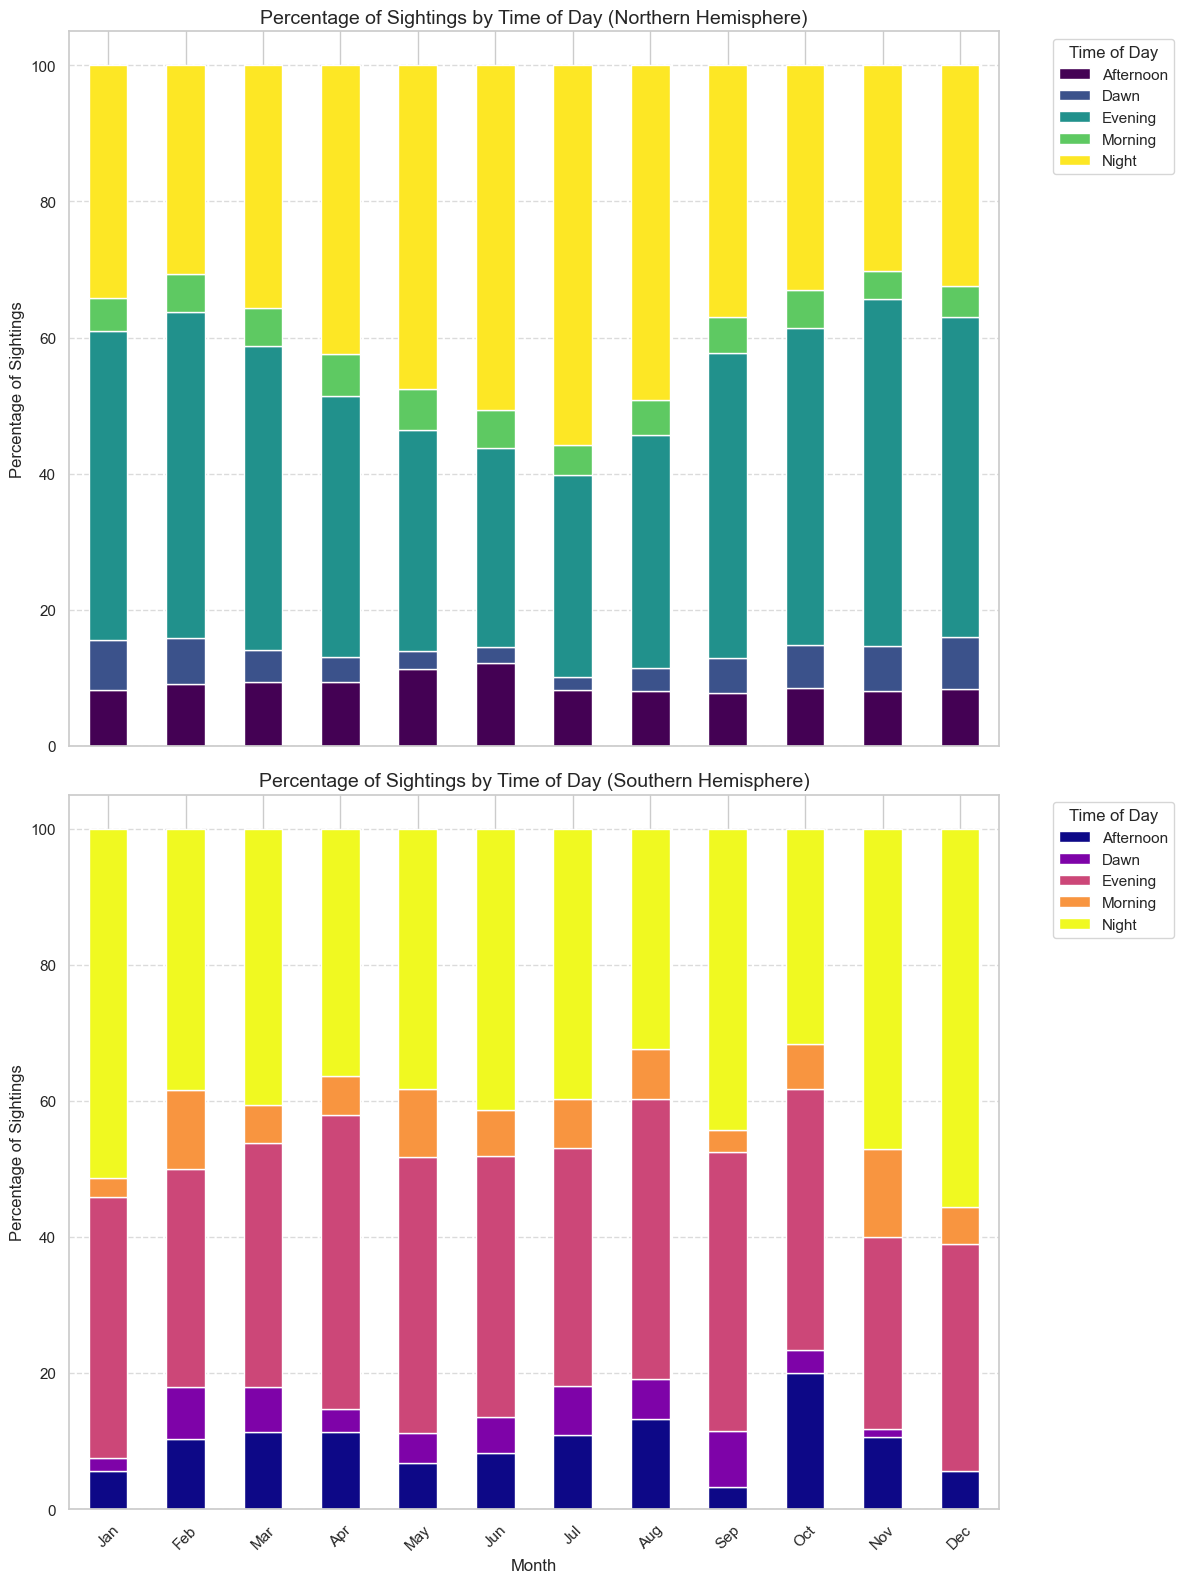

In [90]:

# Define the correct order for months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


def plot_time_of_day_distribution(data, hemisphere, ax, colormap):

    data['month_seen'] = data['month_seen'].map({
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
        })
    
    # Group by month_seen and time_of_day
    month_time_counts = data.groupby(['month_seen', 'time_of_day']).size().reset_index(name='count')
    
    # Make month_seen column a categorical variable so I can get them in the correct order
    month_time_counts['month_seen'] = pd.Categorical(
        month_time_counts['month_seen'], categories=month_order, ordered=True
    )

    month_time_counts = month_time_counts.groupby(['month_seen', 'time_of_day'], as_index=False)['count'].sum()
    
    pivot_table = month_time_counts.pivot(index='month_seen', columns='time_of_day', values='count').fillna(0)
    
    # Calculate values to percentages
    pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
    pivot_table_percentage.head()

    pivot_table_percentage.plot(kind='bar', stacked=True, colormap=colormap, ax=ax)
    ax.set_title(f'Percentage of Sightings by Time of Day ({hemisphere} Hemisphere)', fontsize=14)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Percentage of Sightings', fontsize=12)
    ax.set_xticklabels(month_order, rotation=45)
    ax.legend(title='Time of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Filter data for Northern and Southern hemispheres
north_data = axdf[axdf['hemisphere'] == 'North']
south_data = axdf[axdf['hemisphere'] == 'South']

# Make a plot for each hemisphere.
fig, axes = plt.subplots(2, 1, figsize=(12, 16), sharex=True)

# Plot for the Northern Hemisphere
plot_time_of_day_distribution(north_data, 'Northern', axes[0], 'viridis')

# Plot for the Southern Hemisphere
plot_time_of_day_distribution(south_data, 'Southern', axes[1], 'plasma')


plt.tight_layout()
plt.show()


## For the northern hemisphere evening and night obviously the most opportunistic. Especially during the summer and also, but not as much, in the autumn and spring which is where dawn sightings are at their highest. <br> <br> In the southern hemisphere again evening and night time are the most popular times. Particularly it appears at the heinght of both summer and winter. <br> <br>  Note that evening and night time popularity are somewhat inverse between the two hemispheres with the seasons being reversed.

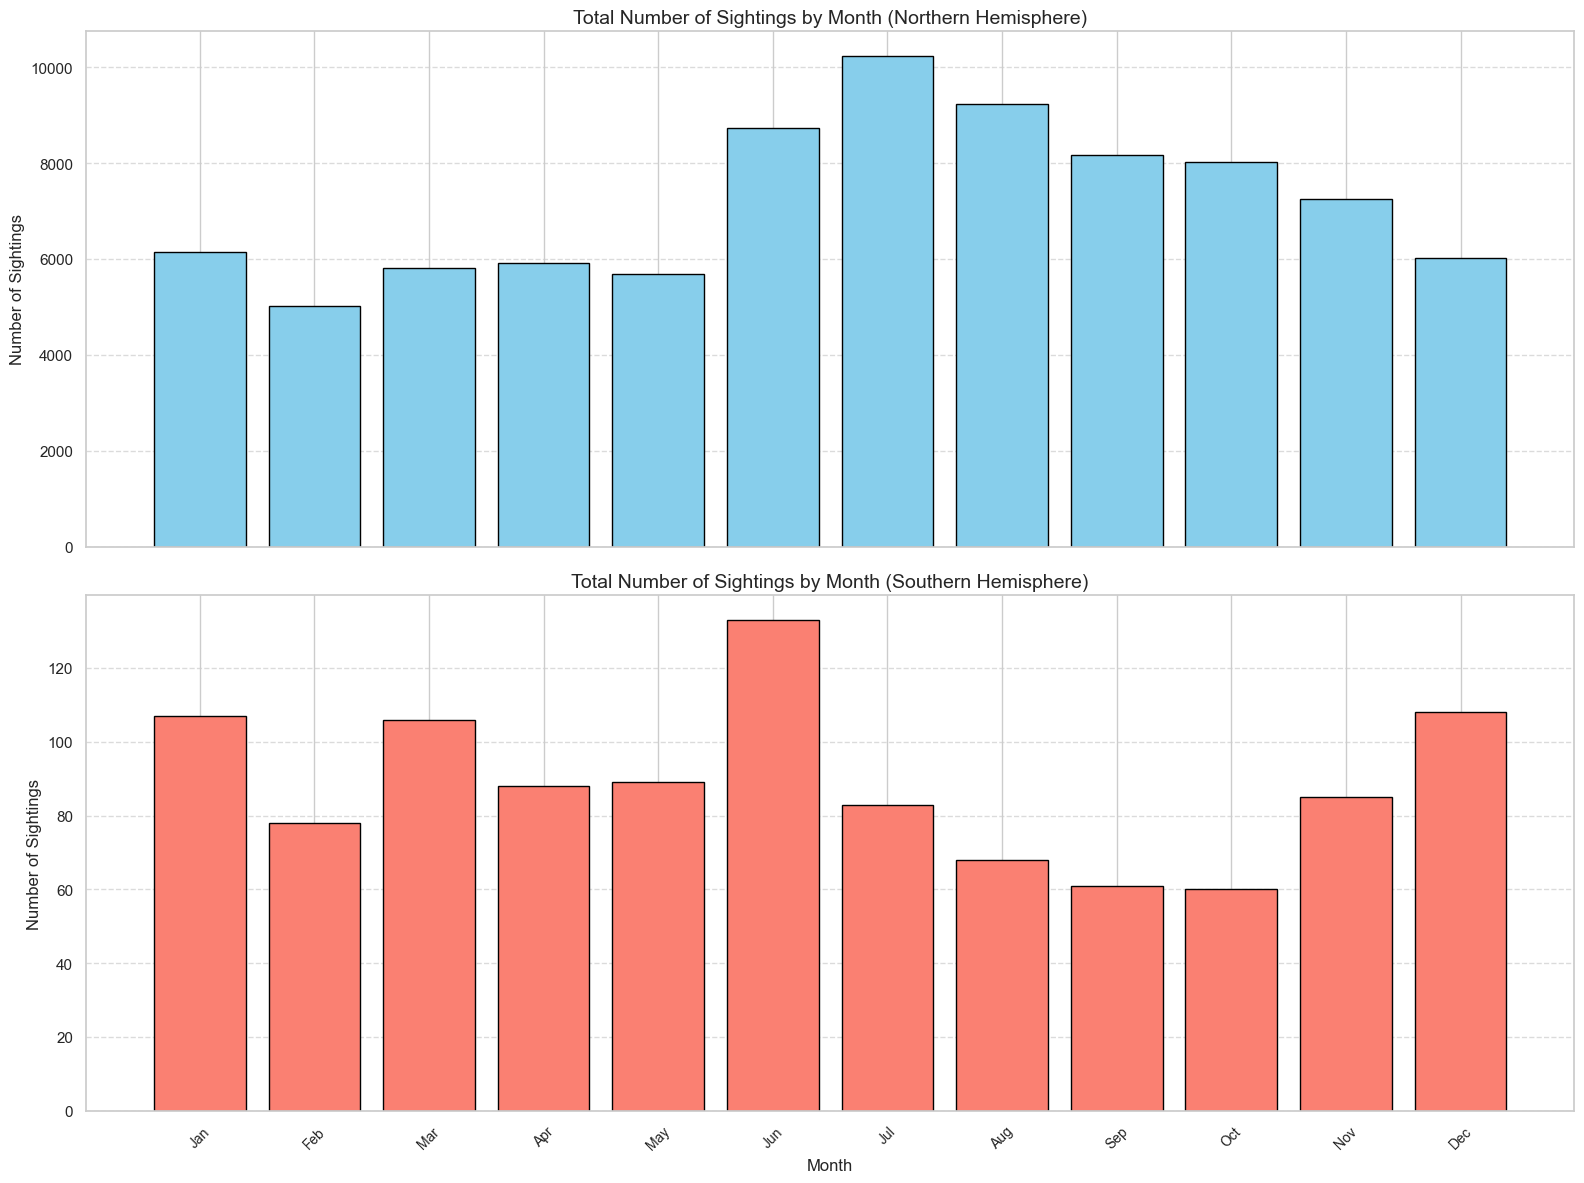

In [91]:
# Define the correct month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

 # Change month_seen to show month abbreviation.
axdf['month_seen'] = axdf['month_seen'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec',
    'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr',
    'May': 'May', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
    'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'
})


# Filter data for Northern and Southern hemispheres
north_data = axdf[axdf['hemisphere'] == 'North']
south_data = axdf[axdf['hemisphere'] == 'South']

# Group and count sightings for each month for Northern Hemisphere
north_monthly_counts = north_data['month_seen'].value_counts()
north_monthly_counts = north_monthly_counts.reindex(month_order, fill_value=0)

# Group and count sightings for each month for Southern Hemisphere
south_monthly_counts = south_data['month_seen'].value_counts()
south_monthly_counts = south_monthly_counts.reindex(month_order, fill_value=0)

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Northern Hemisphere plot
axes[0].bar(north_monthly_counts.index, north_monthly_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Total Number of Sightings by Month (Northern Hemisphere)', fontsize=14)
axes[0].set_ylabel('Number of Sightings', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Southern Hemisphere plot
axes[1].bar(south_monthly_counts.index, south_monthly_counts.values, color='salmon', edgecolor='black')
axes[1].set_title('Total Number of Sightings by Month (Southern Hemisphere)', fontsize=14)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Number of Sightings', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)


plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


### Summer months show the more sightings in the northern hemisphere and I was expecting the same for the southern but June shows the highest number which is the start of the winter.

### I would like to see if the seasons bear any relation to sighting frequency.  I will break down the number of sightings for each season and hemisphere.

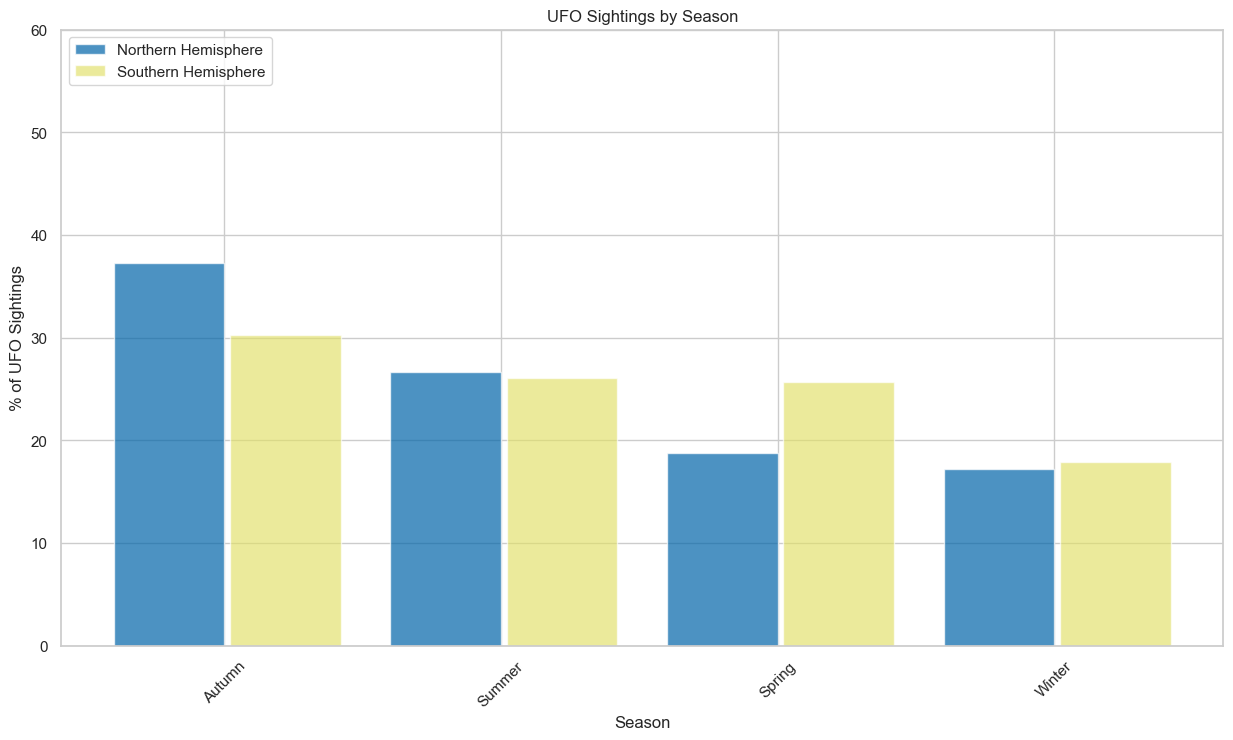

In [92]:
North_Sightings = axdf[axdf['hemisphere'] == 'North']
South_Sightings = axdf[axdf['hemisphere'] == 'South']

# Get the percentage for each season of the total sightings
NorthPct = North_Sightings['season'].value_counts() / len(North_Sightings) * 100
SouthPct = South_Sightings['season'].value_counts() / len(South_Sightings) * 100

pos = list(range(len(NorthPct)))

width = 0.4
fig, ax = plt.subplots(figsize = (15,8))

# Create the bars for each season side by side
plt.bar(pos, NorthPct, width, alpha = .7, color='#0064A9')
plt.bar([p + width*1.05 for p in pos], SouthPct, width, alpha = .65, color='#E1E066')

ax.set_title('UFO Sightings by Season')
ax.set_xlabel('Season')
ax.set_ylabel('% of UFO Sightings')
ax.set_xticks([p + .5 * width for p in pos])
ax.set_xticklabels(NorthPct.index)
plt.xticks(rotation=45)

plt.ylim([0, 60])
plt.legend(['Northern Hemisphere','Southern Hemisphere'], loc='upper left')
plt.show()


### To summarize.  
-  Where do the most UFO sightings occur.
 <br> The U.S. by a considerable margin mfollowed by the U.K. and Canada. There are many other countries visited though.
 - Sightings over the years.
   <br> A slow but steady rise until the mid 90's where there is a huge spike. Possible reasons...
      -  reporting sightings became easier with access to the Internet and portable technology
      -  people's perception especially with media coverage and just taking time to observe whats going on.
      - More secret or classified military exercises and overflights are occurring over populated areas
      - Just more aliens paying a visit.
  - Sightings over the years post 1990
    <br> Steady rise but a bit of a spike in 1995 when UFO films were popular and 2012 which was the end of the world. - Are any particular shapes preferable for visting certain countries (trend between shapes and country)
   <br> No there are no trends between shape and location.
 - Most popular shapes
   <br> Looks like 'light' and 'round' are the two most observed shapes. A 'light' shape could of course be any shape if it was at too great a distance to make out any detail. And 'round' is the conventional shape I suppose. If those cartoons are to be believed anyway.
- Distribution of shapes over the years
  <br> In the early years, with fewer sightings, there were years when only one shape had been observed. Around the early 50's it seems to settle into a general mish-mash apart from an erratic 'round' shape and a huge spike for 'unknown' in 1997? A few shapes seem to be more popular than the others though.
 - Count of new shapes over the years
   <br> The 50's were a good time for first time space vehicle types. The most popular shapes 'light' and 'round' were first observed early on, although 'other' is the first observation. There are two new shapes in quick succession in the late 90's.
 - Sightings percent time of day
   <br> For the most part most fruitful at night. If not night then during the evening, especially closer to the equator.
 - Sightings percent of time of day between hemispheres
   <br> For the northern hemisphere evening and night obviously the most opportunistic. Especially during the summer and also, but not as much, in the autumn and spring which is where dawn sightings are at their highest. <br> In the southern hemisphere again evening and night time are the most popular times. Particularly it appears at the height of both summer and winter. <br> Note that evening and night time popularity are somewhat inverse between the two hemispheres with the seasons being reversed.
 - Sightings per month of the years
   <br> Summer months show the more sightings in the northern hemisphere and I was expecting the same for the southern but June shows the highest number which is the start of the winter.
 - Comparative sightings volume per season between the hemispheres.
   <br> Pretty much the same except for spring which makes for better viewing in the south.